In [1]:
import os
import sys

path_root = os.path.dirname(os.getcwd())

if path_root not in sys.path:
    sys.path.append(path_root)

## Example of going from Document to Graph

In [50]:
import time
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
t5_model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
kg_tokens_dict = ["<H>", "<R>", "<T>"]
num_added_toks = tokenizer.add_tokens(kg_tokens_dict)
text_prefix = "TEXT: "
graph_prefix = "GRAPH: "

model_path = "../models/webNLG_model.pkl"
device = torch.device("mps")
model = torch.load(model_path, map_location=device)

In [58]:
def parse_triple(content):
    entity_ls = set(
        [
            _e.strip()
            for _e in list(
                set(
                    re.findall(r"\s*<H>([\s\w\.\/\-]+)[<$]*", content)
                    + re.findall(r"\s*<R>([\s\w\.\/\-]+)[<$]*", content)
                )
            )
        ]
    )

    hrt_ls = set(
        [
            (_r[0].strip(), _r[1].strip(), _r[2].strip())
            for _r in re.findall(r"<H>([^<]+)<R>([^<]+)<T>([^<]+)", content)
        ]
    )
    return entity_ls, hrt_ls


def gen_json_response(hrt_ls):
    """
    {"graph": { "nodes": [ { "id": 1, "label": "Bob", "color": "#ffffff" }, { "id": 2, "label": "Alice", "color": "#ff7675" } ],
        "edges": [ { "from": 1, "to": 2, "label": "roommate" }, ] } }
    """
    graph = {"nodes": [], "edges": []}
    node_id = 0
    node_dict = {}
    for _h, _r, _t in hrt_ls:
        if _h not in node_dict:
            node_dict[_h] = node_id
            graph["nodes"].append(
                {"id": node_id, "label": _h, "color": "#ffffff"}
            )
            node_id += 1
        if _t not in node_dict:
            node_dict[_t] = node_id
            graph["nodes"].append(
                {"id": node_id, "label": _t, "color": "#ffffff"}
            )
            node_id += 1
        graph["edges"].append(
            {"from": node_dict[_h], "to": node_dict[_t], "label": _r}
        )
    return {"graph": graph}


def get_graph(text: str):
    start = time.time()
    input_content = text
    prefix = text_prefix

    input_content_tmp = tokenizer(
        prefix + input_content,
        return_tensors="pt",
        padding="max_length",
        max_length=500,
    )
    input_ids = input_content_tmp.input_ids.to("mps")
    am = input_content_tmp.attention_mask.to("mps")

    model_outputs = model.generate(
        input_ids=input_ids,
        attention_mask=am,
        num_beams=4,
        length_penalty=2.0,
        max_length=500,
        temperature=0,
    )

    out_content = tokenizer.decode(model_outputs[0], skip_special_tokens=True)
    if "<H>" in out_content:
        entity_pool, hrt_pool = parse_triple(out_content)
        print("-----Graph-----")
        data = gen_json_response(hrt_pool)
    else:
        print(out_content)
        data = {"graph": {"nodes": [], "edges": []}}

    return {"time": time.time() - start, "data": data}


def get_text_size(text, fontsize=10):
    """Estimate the size of the text in display coordinates."""
    fig = plt.figure()
    text_artist = plt.text(0, 0, text, fontsize=fontsize)
    renderer = fig.canvas.get_renderer()
    bbox = text_artist.get_window_extent(renderer=renderer)
    plt.close(fig)
    return bbox.width, bbox.height


def draw_graph(data):
    # Extract nodes and edges from the data
    nodes = data["data"]["graph"]["nodes"]
    edges = data["data"]["graph"]["edges"]

    # Create a NetworkX graph
    G = (
        nx.DiGraph()
    )  # DiGraph for a directed graph, use Graph() for undirected

    # Add nodes
    for node in nodes:
        G.add_node(
            node["id"], label=node["label"], color=node.get("color", "#0000FF")
        )

    # Add edges
    for edge in edges:
        G.add_edge(edge["from"], edge["to"], label=edge["label"])

    # Draw the graph
    pos = nx.spring_layout(G)  # Positions for all nodes

    # Define a transparent blue color
    transparent_blue = (0, 0, 1, 0.5)  # RGB (0, 0, 1) with 0.5 transparency

    # Extract node colors, default to transparent blue
    # node_colors = [node[1].get('color', transparent_blue) for node in G.nodes(data=True)]
    node_colors = [transparent_blue for node in G.nodes(data=True)]

    # Create a figure and set its size
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Draw nodes as ellipses
    for node, (x, y) in pos.items():
        label = G.nodes[node]["label"]
        width, height = get_text_size(label, fontsize=10)
        width /= 100  # Scale width to fit the graph
        ellipse = patches.Ellipse(
            (x, y),
            width=width + 0.2,
            height=0.1,
            color=node_colors[node],
            alpha=0.5,
        )
        ax.add_patch(ellipse)
        ax.text(
            x,
            y,
            label,
            horizontalalignment="center",
            verticalalignment="center",
        )

    # Draw edges with increased width
    nx.draw_networkx_edges(
        G, pos, arrowstyle="->", arrowsize=10, ax=ax, width=2
    )

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Remove axes
    ax.set_axis_off()

    # Display the graph
    plt.show()

In [9]:
from src.utils import load_json

llm_path = "../example_output/example_pipeline_14_05_24/llm.json"
llm_output = load_json(llm_path)

In [39]:
get_graph(text=llm_output[0])

-----Graph-----


{'time': 7.736911058425903,
 'data': {'graph': {'nodes': [{'id': 0,
     'label': 'Jeremiah Bednar',
     'color': '#ffffff'},
    {'id': 1, 'label': 'Acute Viral Pharyngitis', 'color': '#ffffff'},
    {'id': 2, 'label': 'acute viral pharyngitis', 'color': '#ffffff'},
    {'id': 3, 'label': 'Acute pharyngitis', 'color': '#ffffff'},
    {'id': 4, 'label': '4798819344', 'color': '#ffffff'},
    {'id': 5, 'label': 'Adverse pharyngitis', 'color': '#ffffff'},
    {'id': 6, 'label': 'January 1, 2009', 'color': '#ffffff'}],
   'edges': [{'from': 0, 'to': 1, 'label': 'diagnosis'},
    {'from': 0, 'to': 2, 'label': 'diagnosis'},
    {'from': 3, 'to': 4, 'label': 'clinical Diagnosis'},
    {'from': 3, 'to': 5, 'label': 'diagnosis'},
    {'from': 0, 'to': 6, 'label': 'birth Date'}]}}}

In [40]:
get_graph(text=llm_output[1])

-----Graph-----


{'time': 7.131211042404175,
 'data': {'graph': {'nodes': [{'id': 0,
     'label': 'Acute viral pharyngitis',
     'color': '#ffffff'},
    {'id': 1,
     'label': 'Sore throat and fever for the past 2 days',
     'color': '#ffffff'},
    {'id': 2, 'label': 'Antiviral medication', 'color': '#ffffff'},
    {'id': 3,
     'label': 'Acute viral pharyngitisège protocol',
     'color': '#ffffff'},
    {'id': 4, 'label': 'Temeka McCullough', 'color': '#ffffff'},
    {'id': 5, 'label': 'September 14, 2000', 'color': '#ffffff'},
    {'id': 6, 'label': '1766306217', 'color': '#ffffff'}],
   'edges': [{'from': 0, 'to': 1, 'label': 'symptoms'},
    {'from': 0, 'to': 2, 'label': 'course'},
    {'from': 3, 'to': 4, 'label': 'Patient'},
    {'from': 4, 'to': 5, 'label': 'birth Date'},
    {'from': 0, 'to': 6, 'label': 'doctor'},
    {'from': 0, 'to': 6, 'label': 'diagnosis'}]}}}

In [43]:
data = get_graph(text=llm_output[2])
data

-----Graph-----


{'time': 6.473246097564697,
 'data': {'graph': {'nodes': [{'id': 0,
     'label': 'Huey Orn',
     'color': '#ffffff'},
    {'id': 1, 'label': 'Viral sinusitis', 'color': '#ffffff'},
    {'id': 2,
     'label': 'fever and cough in the past 48 hours',
     'color': '#ffffff'},
    {'id': 3, 'label': 'viral sinusitis', 'color': '#ffffff'},
    {'id': 4, 'label': 'ibuprofen', 'color': '#ffffff'},
    {'id': 5, 'label': 'acetaminophen', 'color': '#ffffff'},
    {'id': 6, 'label': 'Allergies', 'color': '#ffffff'}],
   'edges': [{'from': 0, 'to': 1, 'label': 'clinical Diagnosis'},
    {'from': 0, 'to': 2, 'label': 'history'},
    {'from': 0, 'to': 3, 'label': 'diagnosis'},
    {'from': 4, 'to': 5, 'label': 'medication'},
    {'from': 0, 'to': 6, 'label': 'history'}]}}}

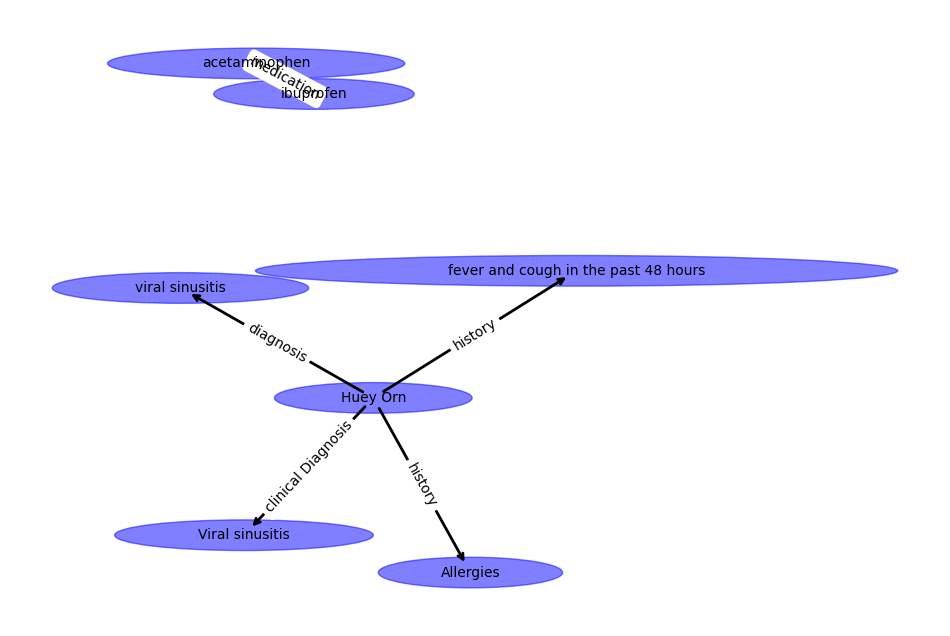

In [60]:
draw_graph(data)

### Example of going from Entities Extracted to Graph

In [27]:
import networkx as nx
from pyvis.network import Network
import networkx as nx

In [15]:
from src.utils import load_json

extraction_path = "../example_output/example_pipeline_14_05_24/extraction.json"
extraction_output = load_json(extraction_path)

In [17]:
entity_list = ["person", "diagnosis", "nhs number", "date of birth"]

nx.html


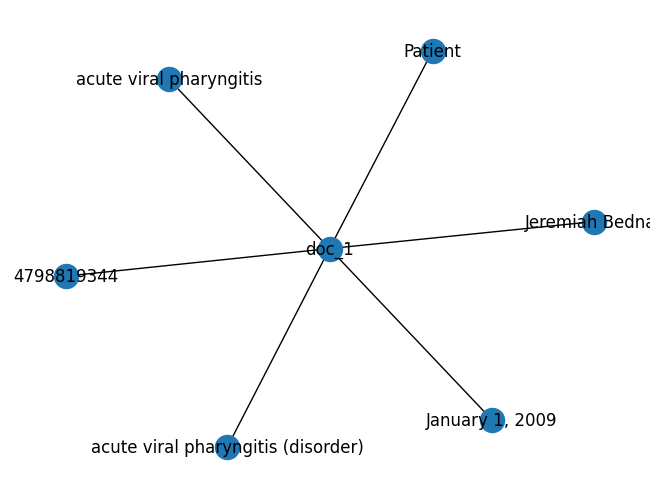

In [29]:
data = extraction_output[0]["Entities"]
# Initialize a graph
G = nx.Graph()

# Add a starter node (document ID)
doc_id = "doc_1"
G.add_node(doc_id, label="document")

# Add nodes and edges based on the data
for entry in data:
    node_label = entry["label"]
    node_text = entry["text"]
    node_score = entry["score"]

    G.add_node(node_text, label=node_label, score=node_score)
    G.add_edge(doc_id, node_text, label=node_label)

nx.draw(G, with_labels=True)
nt = Network("500px", "500px")
nt.from_nx(G)
nt.show("nx.html", notebook=False)